In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as st

from datetime import timedelta, datetime
from matplotlib import style
import matplotlib.mlab as mlab


# MESSURING MARKET RISK BY MONTE CARLO SIMULATION

## Author: Ivaylo Kanov & the Math Concepts for Developers Course Students
## Used data:
[Yahoo.Finance](https://finance.yahoo.com/quote/intc/history/) and 
[Higher School of Agribusiness](https://uard.bg/files/custom_files/files/documents/New%20knowledge/year1_n4/paper_georgiev1_y1n4.pdf)

## Summary
The purpose of this article is to present in detail the calculation of maximum expected loss in market risk using Monte Carlo simulation.

The Monte Carlo Simulation Approach was discovered in the mid-40s by three scientists Neumann, Ulm and Metropolis. They were working on the Manhattan project to create an atomic bomb, which had an unsolvable problem when they came up with the idea of randomly generated numbers and probability theory. This idea proved to be quite successful and was named "Monte Carlo" in the name of the famous casino in Monaco. From this point on, this model has become key to investigating and modeling events with a high degree of uncertainty and risk. The drawback of the model is that for more accuracy, 10000 simulations are made, making it slow.

The idea of the model from the latest current price to simulate a huge number of random variables with certain characteristics corresponding to the distribution of available data.

## Read data:

In [3]:
data = pd.read_csv('INTC-01.01-23.05.2018.csv')
data.set_index('Date', inplace=True)
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
5/17/2018,54.549999,55.439999,54.419998,54.810001,54.810001,16872600
5/18/2018,54.529999,54.540001,53.470001,53.500000,53.500000,23679900
5/21/2018,54.360001,55.220001,53.860001,54.320000,54.320000,25367400
5/22/2018,54.730000,55.049999,54.049999,54.450001,54.450001,19009600
5/23/2018,54.000000,55.230000,53.840000,55.209999,55.209999,20496500


The column I'm going to use is a column "Close" It reflects the cost of finishing every day.

In [4]:
price = data["Close"]
last_price = price[-1]

To calculate the average standard deviation and the average value, I calculate the daily price change.

In [5]:
returns = price.pct_change()
returns = returns[1:]
daily_vol = returns.std()
avg_daily_ret = returns.mean()
variance = returns.var()
returns.head()

Date
1/3/2018   -0.033938
1/4/2018   -0.018338
1/5/2018    0.006977
1/8/2018    0.000000
1/9/2018   -0.025034
Name: Close, dtype: float64

## Global variables and functions for plotting.

In [6]:
#global
num_simulations = 1000
predicted_days = 7

In [28]:
def plot_function(model):
    fig = plt.figure(figsize=(8,6))

   
     
    title = "Monte Carlo Simulation: " + str(predicted_days) + " Days"
    plt.plot(model)
    fig.suptitle(title,fontsize=18, fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Price ($USD)')
    plt.grid(True,color='grey')
    plt.axhline(y=last_price, color='r', linestyle='-')
    plt.show()

In [8]:
def plot_VaR(model):

    price_array = model.iloc[-1, :]
    price_array = sorted(price_array, key=int)  
    var =  np.percentile(price_array, 1)
        
    val_at_risk = last_price - var
    print ("Value at Risk: ", val_at_risk)
        
    #Histogram
    fig = plt.figure(figsize=(8,6))
    plt.hist(price_array,normed=True, bins=20)
    plt.xlabel('Price')
    plt.ylabel('Probability')
    plt.title(r'Histogram of Speculated Stock Prices', fontsize=18, fontweight='bold')
    plt.axvline(x=var, color='r', linestyle='--', label='Price at Confidence Interval: ' + str(round(var, 2)))
    plt.axvline(x=last_price, color='k', linestyle='--', label = 'Current Stock Price: ' + str(round(last_price, 2)))
    plt.legend(loc="upper right")
    plt.show()

In [9]:
def metrics(model):
    price_array = model.iloc[-1, :]
    percentile_list = [99, 97.5, 95, 90]
    print ('#----------------------Percentiles--------------------------------#')
    for per in percentile_list:
        print ("{} th Percentile: ".format(per), np.percentile(price_array, per))
    print()
    print ('#----------------------Descriptive Stats-------------------#')
    price_array = model.iloc[-1, :]
    print (price_array.describe())

## Models

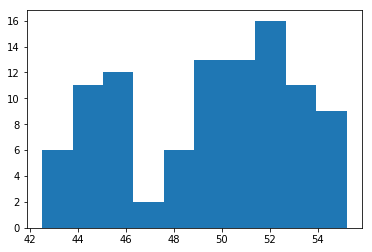

In [10]:
plt.hist(price, bins=10)
plt.show()

For the purpose of the project I will use two models. Gaussian model and Brownian pattern. I will test a Gaussian model, which is a normal distribution for the purposes of experience, although it does not look like Gaussian distribution. :)

## Model 1. Gaussian distribution

The idea of this simulation is to each next period simulate random numbers in the range of 0 to the standard deviation of the model to offset the price. The simulations will be 1000 per count for a period of 7 days ahead. The big period leads to a great deal of distraction and a bigger mistake, so a period of more than 10 days is seldom chosen. The time interval in years is 1/250 = 0.0040.

In [11]:
def monte_carlo_standart_sim(num_simulations, predicted_days):
       
        
        simulation_df = pd.DataFrame()
 
        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            count = 0
            
            price_series = []
            
            #Append Start Value
            price = last_price
            price_series.append(price)
            
            #Series for Preditcted Days
            for i in range(predicted_days):
                if count == 251:
                    break
                price = price_series[count] * (1 + np.random.normal(0, daily_vol))
                price_series.append(price)
                count += 1
        
            simulation_df[x] = price_series
        return simulation_df

In [12]:
MCSS = monte_carlo_standart_sim(num_simulations, predicted_days)
MCSS

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,...,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999
1,52.940144,53.784014,56.310833,54.998189,56.157878,55.812060,55.077883,56.347303,56.006137,57.502133,...,56.174622,56.232620,56.079610,56.721752,55.148229,55.120365,54.474123,55.391988,54.047733,55.815005
2,53.854557,55.308925,53.960341,54.495090,55.573465,56.170642,53.762027,56.596115,57.445522,57.458982,...,56.421268,55.956097,54.855772,56.836519,53.600358,53.418221,55.704460,55.913119,52.766024,55.701819
3,54.328620,54.566447,55.780725,55.317184,56.397119,55.368408,55.940719,56.853859,58.227609,56.794425,...,57.873127,55.968807,55.500241,56.444525,51.764424,53.320095,56.852480,54.501208,51.662317,55.877156
4,51.892393,55.358350,56.094563,53.683693,56.394390,54.650668,52.922697,55.589950,58.509179,58.335120,...,61.278883,57.432124,57.719520,55.479301,49.730753,52.636278,60.526623,54.329993,51.992725,55.050393
5,50.452221,54.541748,56.545936,51.780086,54.462442,55.189673,52.523775,57.504432,59.221110,56.257131,...,61.344997,59.156325,60.246706,53.339830,48.945692,52.328003,61.020647,52.504105,53.059504,57.596631
6,50.871826,57.152411,58.809747,52.859525,54.020607,54.352149,52.036248,55.307797,62.122560,57.061621,...,64.241123,60.775508,62.310394,50.807371,48.789379,49.446488,62.698578,52.238409,52.876135,57.535716
7,49.236994,56.885324,60.580759,52.549247,53.032175,53.480829,52.824574,56.055108,59.987308,55.414507,...,63.338533,61.714334,60.975319,50.014754,48.643936,49.455206,61.627289,52.062701,53.204706,58.444058


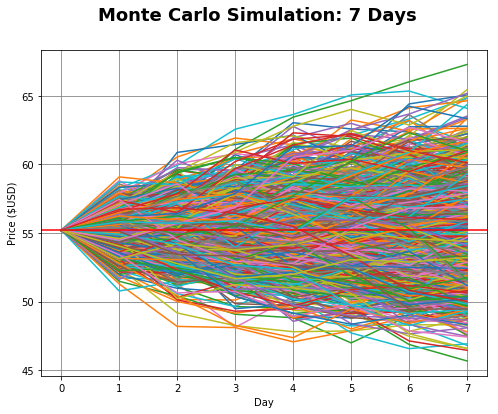

In [30]:
plot_function(MCSS)

Value at Risk:  7.56418261513


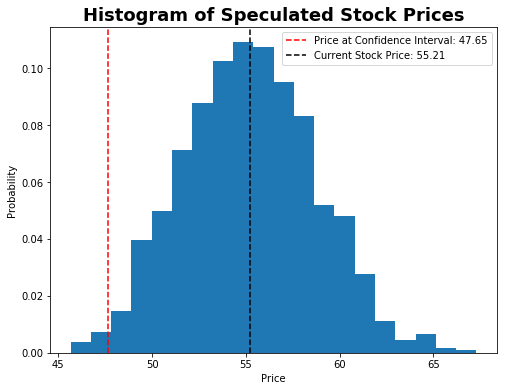

In [14]:
plot_VaR(MCSS)

In [15]:
metrics(MCSS)

#----------------------Percentiles--------------------------------#
99 th Percentile:  63.5313250016
97.5 th Percentile:  62.001181978
95 th Percentile:  61.0196070097
90 th Percentile:  59.8071264284

#----------------------Descriptive Stats-------------------#
count    1000.000000
mean       55.200319
std         3.516421
min        45.661817
25%        52.782972
50%        55.191484
75%        57.600202
max        67.290911
Name: 7, dtype: float64


## Model 2. Brownian motation.

Brown's movement describes the accidental wandering of a particle in an infinitely small amount of time. From a statistical point of view, this is a random allocation process. The Brown movement in its original form can also accept negative values and therefore can not be used directly to predict the movement of financial instruments prices. Therefore, his mathematical modification applies to the geometric Browun movement. In the simulation process, the input data is subjected to a combined impact of drift and shock.

In [16]:
def brownian_motion(num_simulations, predicted_days):
       
 
        #Assuming drift here
        simulation_df = pd.DataFrame()
        
        #Create Each Simulation as a Column in df
        for x in range(num_simulations):
            
            #Inputs
            count = 0

            daily_drift = avg_daily_ret - (variance/2)
            drift = daily_drift - 0.5 * daily_vol ** 2
            
            #Append Start Value    
            prices = []
            
            shock = drift + daily_vol * np.random.normal()
            last_price * math.exp(shock)
            prices.append(last_price)
            
            for i in range(predicted_days):
                if count == 251:
                    break
                shock = drift + daily_vol * np.random.normal()
                price = prices[count] * math.exp(shock)
                prices.append(price)
                
        
                count += 1
            simulation_df[x] = prices
        return simulation_df

In [17]:
MCBM = brownian_motion(num_simulations, predicted_days)
price_array = MCBM.iloc[-1, :]
MCBM


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,...,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999,55.209999
1,55.096311,53.951053,54.112911,54.634686,55.132371,54.959895,52.808731,54.393151,54.983043,58.014871,...,53.229569,56.441308,53.216921,55.593742,56.665399,57.380201,56.271834,54.938382,54.850918,55.827506
2,53.716478,52.802429,53.632663,53.859283,53.705036,53.867690,56.609798,55.103777,55.814158,57.248856,...,50.939513,56.284328,53.801644,55.891238,59.145838,58.229093,54.033227,53.994247,53.536647,55.133152
3,53.855407,54.274918,52.454298,52.782309,53.657934,54.448605,58.943593,54.439392,56.823919,57.629027,...,51.675214,57.339382,54.145989,55.645249,59.523803,59.247079,52.889199,57.812629,55.506820,53.713490
4,56.041639,54.571108,51.720645,53.367113,51.638193,54.582625,60.057063,57.403839,56.250291,55.918414,...,52.575160,56.615222,54.523281,56.204394,60.542797,59.155822,52.917927,59.092669,56.036979,52.879871
5,55.512299,55.393564,52.194088,51.007348,51.708694,54.310491,62.285011,59.615544,57.525593,58.166480,...,52.021341,58.253337,54.735588,55.442681,58.435079,56.997505,53.024945,57.824043,58.245101,51.992513
6,56.528143,54.735506,50.551894,50.255695,52.044158,52.906310,61.015684,59.566650,57.065523,58.187801,...,52.331988,57.472099,55.017915,55.892474,56.781054,56.297426,54.418328,59.420506,58.673849,50.511761
7,54.963387,52.295554,50.135324,50.463368,50.673651,52.345379,61.699467,61.108055,57.402528,57.239226,...,52.361569,57.665648,58.124698,54.249076,58.005045,56.827428,53.439163,61.494375,57.100152,51.515199


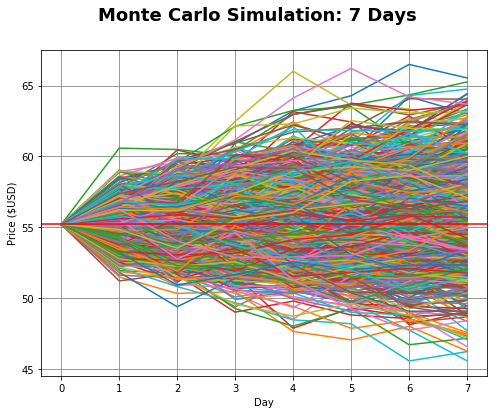

In [18]:
plot_function(MCBM)

Value at Risk:  7.62142982102


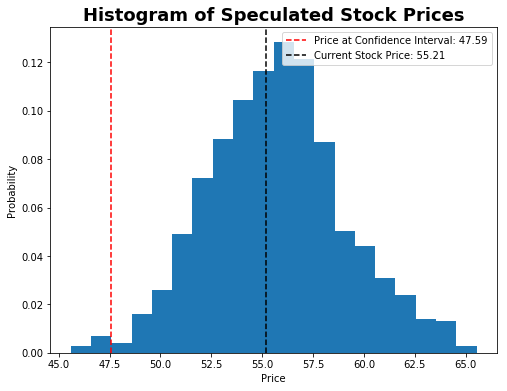

In [19]:
plot_VaR(MCBM)

In [20]:
metrics(MCBM)

#----------------------Percentiles--------------------------------#
99 th Percentile:  63.7695166692
97.5 th Percentile:  62.675296408
95 th Percentile:  61.671822084
90 th Percentile:  60.1182918625

#----------------------Descriptive Stats-------------------#
count    1000.000000
mean       55.705490
std         3.366226
min        45.593316
25%        53.394734
50%        55.695483
75%        57.689285
max        65.536324
Name: 7, dtype: float64


Model 2 gives a smaller error and I think it's better for the case.

### I hope the project was interesting to you. :)